## Imports

In [33]:
import os
import sys
sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

from scipy import stats

np.random.seed(1234)
plt.style.use('default')

## Select Cluster and GWAS

In [34]:
cluster = '1'

snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')

## Prepare Major Alleles

In [59]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num onehot sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(7,8):
    effect_file = '/oak/stanford/groups/akundaje/soumyak/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    print(merged_effect_scores.shape)
    
merged_effect_scores = merged_effect_scores / (fold + 1)

Num onehot sequences: 642
(642, 1000, 4)


## Prepare Minor Alleles

In [61]:
noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num onehot sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(7,8):
    noneffect_file = '/oak/stanford/groups/akundaje/soumyak/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    print(merged_noneffect_scores.shape)
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

Num onehot sequences: 642
(642, 1000, 4)


## Prepare DataFrame

In [62]:
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
effect_rank = []
noneffect_rank = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][490:510]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][490:510]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank

## Find Alternate Alleles that Break Accessibility

In [50]:
neg_snps = snps.loc[snps['allele_ratio'] >= 1]
neg_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref    alt  \
133  chr17    4899021    4899022   rs55681486      T         C   T      C   
222  chr17   45852666   45852667   rs62054825      G         A   G      A   
41   chr11   60251676   60251677     rs636317      C         T   C      T   
430   chr2   95324017   95324018    rs3772034      G         A   G      A   
240  chr17   45896863   45896864   rs62056782      T         C   C      T   
47   chr11   65834088   65834089   rs17854357      C         G   G    C,T   
630   chr8   27369272   27369273     rs755951      C         A   A    C,T   
575   chr4   89836583   89836584    rs2619361      A         C   C      A   
63   chr11  121590239  121590240   rs77819448      G         A   A      G   
597   chr5  134594837  134594838   rs17167632      G         A   G      A   
405  chr19   45001090   45001091   rs35577563      G         C   C      G   
318  chr17   46213482   46213483   rs76475191      T         A   T      A   
539   chr4   89723193   89723194   rs79596632      G         A   G      A   
330  chr17   61862882   61862883   rs16945692      G         A   A      G   
12    chr1  232521986  232521987   rs34331262      G         A   A    C,G   
587   chr4   90290372   90290373   rs75541595      G         A   G      A   
621   chr8   11853639   11853640    rs1293295      C         A   C    A,T   
425   chr2   95301997   95301998    rs9989786      G         A   A      G   
270  chr17   45959712   45959713  rs113793114      G         A   G      A   
72   chr12   40499862   40499863  rs117937897      G         A   G    A,C   
294  chr17   46038519   46038520   rs12150090      T         C   C    G,T   
264  chr17   45958920   45958921   rs62063275      G         A   A      G   
4     chr1  171741264  171741265    rs2298914      T         C   C      T   
324  chr17   46758935   46758936    rs9912530      T         C   T      C   
366  chr19   44723890   44723891  rs150820726      T         A   A      T   
242  chr17   45897109   45897110   rs80346216      T         G   G      T   
91   chr16   30010080   30010081    rs1140239      T         C   C    A,T   
352  chr19   18425605   18425606    rs8106096      G         C   C    A,G   
565   chr4   89801281   89801282    rs2619373      G         A   G      A   
302  chr17   46093047   46093048   rs62061790      G         A   G      A   
..     ...        ...        ...          ...    ...       ...  ..    ...   
92   chr16   30012464   30012465   rs12325400      G         C   C      G   
93   chr16   30012464   30012465   rs12325400    NAN       NAN   C      G   
502   chr4     875385     875386   rs11734537    NAN       NAN   A      G   
268  chr17   45959547   45959548   rs62063278      T         C   C      T   
246  chr17   45907880   45907881   rs62056811      T         C   C      T   
208  chr17   45748358   45748359   rs62054439      T         G   G      T   
11    chr1  232521900  232521901   rs35186494      T         C   T      C   
373  chr19   44844995   44844996   rs10426423      T         C   C  A,G,T   
623   chr8   22604860   22604861    rs3735901      T         C   T      C   
278  chr17   45997068   45997069   rs62063851      G         C   C      G   
237  chr17   45896046   45896047   rs78720789      G         A   A      G   
382  chr19   44915228   44915229   rs12691088      A         G   G    A,C   
329  chr17   49353733   49353734   rs28618326      C         T   T      C   
103  chr16   30999861   30999862    rs4889606      G         A   A      G   
50   chr11   83827385   83827386    rs2040313      G         A   G      A   
284  chr17   46002200   46002201   rs17573447      T         C   C      T   
371  chr19   44758447   44758448   rs34967149      T         C   C      T   
552   chr4   89765967   89765968    rs3775427      G         A   G      A   
26   chr11   47354896   47354897    rs1057233      A         G   G      A   
177  chr17   45705088   45705089   rs62056881      T         G   G      T   
30 

## Visualize Top Sequences

In [51]:
for idx in neg_snps.index[:5]:
    #for idx in [60]:
    print("Index: ", idx, " Importance: ", neg_snps.at[idx, 'effect_score'], " RSID: ", neg_snps.at[idx, 'rsid'], 
          ' ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'])
    print("Effect Allele: ", neg_snps.at[idx, 'effect'], ' Effect Sequence: ', effect_seqs[idx][490:510])
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", neg_snps.at[idx, 'noneffect_score'], " RSID: ", neg_snps.at[idx, 'rsid'])
    print("Noneffect Allele: ", neg_snps.at[idx, 'noneffect'], ' Noneffect Sequence: ', noneffect_seqs[idx][490:510])
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Allele Ratio: ", neg_snps.at[idx, 'allele_ratio'], " RSID: ", neg_snps.at[idx, 'rsid'])
    print("Noneffect - Effect: ", neg_snps.at[idx, 'noneffect'] + ' - ' + neg_snps.at[idx, 'effect'])
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

Index:  133  Importance:  0.2871860181  RSID:  rs55681486   chr17 : 4899021 - 4899022
Effect Allele:  T  Effect Sequence:  CTCCTGATCTCTCGTGCTCT


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f1f39ccb1e0> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f1f39cc5158> (for post_execute):


KeyboardInterrupt: 

In [63]:
pd.set_option('display.max_columns', None)
snps.loc[snps['rsid'] == 'rs1237999']

chr     start       end       rsid effect noneffect ref alt major minor  \
59  chr11  86103987  86103988  rs1237999      A         G   G   A     A     G   
60  chr11  86103987  86103988  rs1237999      G         A   G   A     A     G   

   direction                  pvalue             source_gwas  locus_num  \
59         +               1.463e-13  Alzheimers_Kunkle_2019         16   
60         -  7.1431480803899985e-16  Alzheimers_Jansen_2018         16   

    ld_tag_chr  ld_tag_pos  r2_with_ld_tag  effect_score  noneffect_score  \
59          11    86103988             1.0      0.120909         0.184106   
60          11    86103988             1.0      0.184106         0.120909   

    effect_center  noneffect_center  effect_ratio  noneffect_ratio  \
59       0.027234          0.039681      0.009049         0.071369   
60       0.039681          0.027234      0.071369         0.009049   

    allele_ratio  effect_rank  noneffect_rank  
59      0.686143     0.006209        0.103950  
60      1.456520     0.103950        0.006209

## Find Alternate Alleles that Improve Accessibility

In [52]:
pos_snps = snps.loc[snps['allele_ratio'] < 1]
pos_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect ref    alt  \
132  chr17    4899021    4899022   rs55681486      C         T   T      C   
42   chr11   60251676   60251677     rs636317      T         C   C      T   
417  chr19   45326123   45326124     rs344792      A         G   G      A   
629   chr8   27369272   27369273     rs755951      A         C   A    C,T   
311  chr17   46130945   46130946    rs6503457      T         G   G  A,C,T   
576   chr4   89836583   89836584    rs2619361      C         A   C      A   
484   chr3   52232789   52232790  rs140991232      G         C   G      C   
404  chr19   45001090   45001091   rs35577563      C         G   C      G   
253  chr17   45910838   45910839    rs2435204      G         A   A      G   
474   chr3   18240966   18240967   rs35274326      G         C   C      G   
358  chr19   18462023   18462024    rs8103622      T         C   C      T   
482   chr3   49007333   49007334    rs6781790      T         C   C      T   
638   chr9   17579764   17579765   rs12683178      G         C   C      G   
304  chr17   46130520   46130521   rs10514904      T         C   C      T   
460   chr2  134762963  134762964   rs13033373      T         C   T      C   
418  chr19   45326535   45326536     rs344791      C         G   G      C   
188  chr17   45740531   45740532   rs80157557      G         A   G      A   
498   chr3  122458998  122458999   rs56118506      T         C   C      T   
641   chr9   33846423   33846424    rs4515641      G         A   A      G   
65   chr12   33530906   33530907     rs935534      G         A   G      A   
351  chr19   18425605   18425606    rs8106096      C         G   C    A,G   
239  chr17   45896285   45896286   rs62056780      T         C   C    G,T   
564   chr4   89801281   89801282    rs2619373      A         G   G      A   
36   chr11   60169283   60169284     rs617135      G         A   A      G   
174  chr17   45704411   45704412   rs17762361      A         G   A      G   
602   chr6   27772520   27772521     rs760587      C         A   C      A   
542   chr4   89723356   89723357    rs8180214      G         A   G      A   
626   chr8   22673949   22673950   rs11985023      T         C   C      T   
589   chr5  102971887  102971888    rs6881225      T         C   T      C   
583   chr4   89837895   89837896    rs2619363    NAN       NAN   G    C,T   
..     ...        ...        ...          ...    ...       ...  ..    ...   
604   chr6   40897500   40897501  rs143202663      T         C   T      C   
535   chr4   89715858   89715859     rs356218    NAN       NAN   A    G,T   
135  chr17    4903422    4903423   rs34461890      C         T   T      C   
262  chr17   45949128   45949129   rs74531363      G         A   A    G,T   
616   chr7   65960529   65960530   rs62470932      T         C   C      T   
325  chr17   46759286   46759287     rs199530      A         G   G      A   
538   chr4   89723129   89723130   rs17016071      G         A   A      G   
590   chr5  103010211  103010212    rs1826673      G         A   G      A   
46   chr11   60265897   60265898    rs7930318      T         C   C      T   
209  chr17   45748545   45748546   rs17334797      A         G   A      G   
559   chr4   89800408   89800409    rs2737024      A         G   A      G   
485   chr3   52237762   52237763  rs146527642      G         C   G      C   
611   chr7   23106492   23106493    rs2072368      T         C   C      T   
525   chr4   76238563   76238564    rs1441920      G         A   A      G   
271  chr17   45965416   45965417   rs56294117      G         A   G      A   
451   chr2  127107527  127107528  2_127107528    NAN       NAN   .      .   
141  chr17    5111493    5111494   rs56229705      A         G   G    A,C   
159  chr17   45664085   45664086   rs17760577      T         C   C      T   
343  chr18   31506485   31506486   rs59698374      G         A   A      G   
516   chr4     968130     968131   rs62294486      T         C   C    A,T   
105

## Visualize Top Sequences

Index:  132  Importance:  0.2871860181  RSID:  rs55681486
Noneffect Allele:  T  Noneffect Sequence:  CTCCTGATCTCTCGTGCTCT


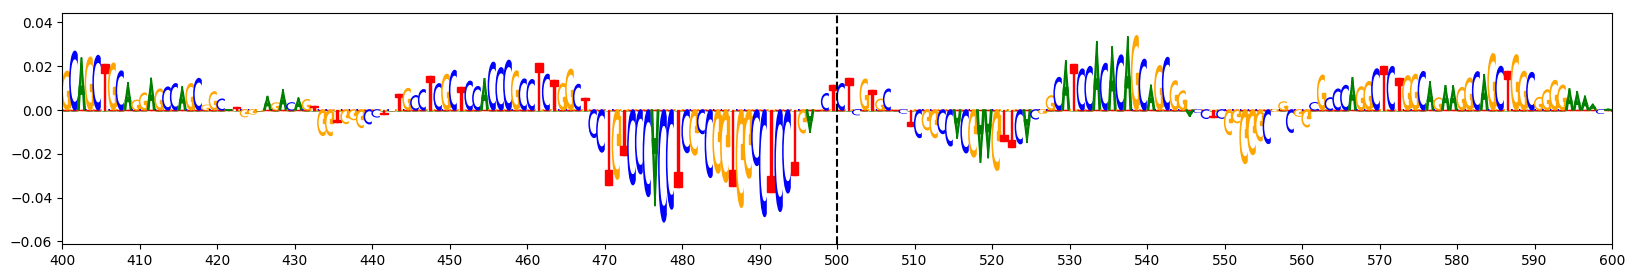

Index:  132  Importance:  0.0666041830000001  RSID:  rs55681486   chr17 : 4899021 - 4899022
Effect Allele:  C  Effect Sequence:  CTCCTGATCCCTCGTGCTCT


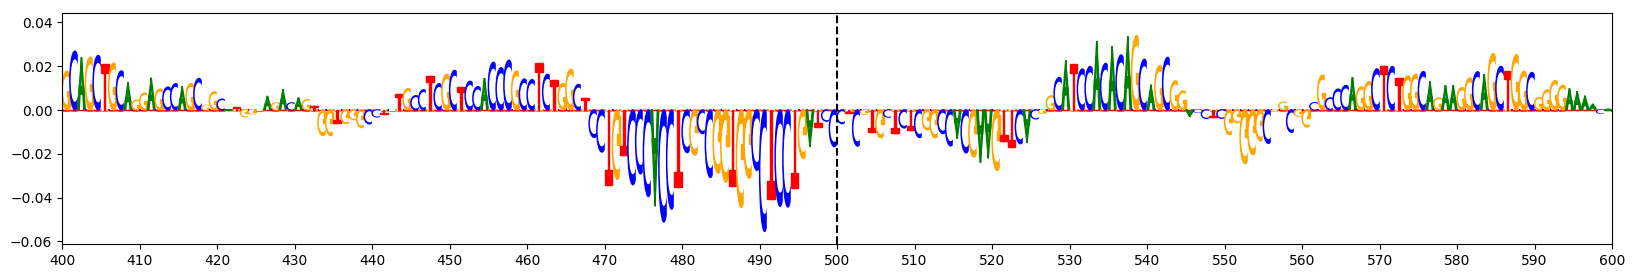

Index:  132  Allele Ratio:  0.0  RSID:  rs55681486
Effect - Noneffect:  C - T


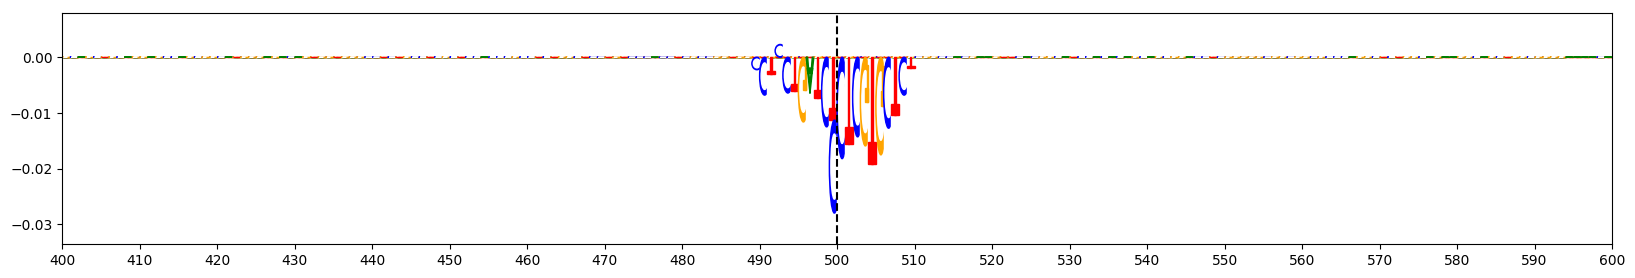

Index:  42  Importance:  3.7660480835999994  RSID:  rs636317
Noneffect Allele:  C  Noneffect Sequence:  CTTTGCTGCCATCTGCTGGG


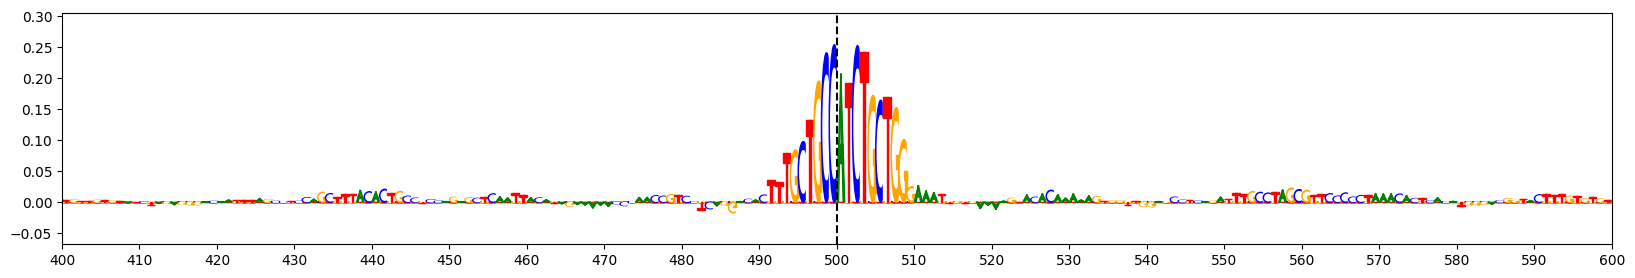

Index:  42  Importance:  1.7253778934000001  RSID:  rs636317   chr11 : 60251676 - 60251677
Effect Allele:  T  Effect Sequence:  CTTTGCTGCTATCTGCTGGG


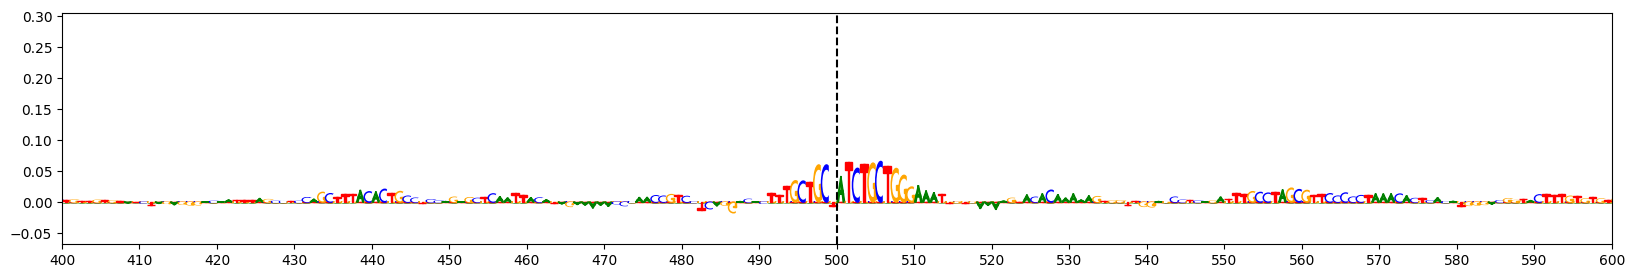

Index:  42  Allele Ratio:  0.3228671367935101  RSID:  rs636317
Effect - Noneffect:  T - C


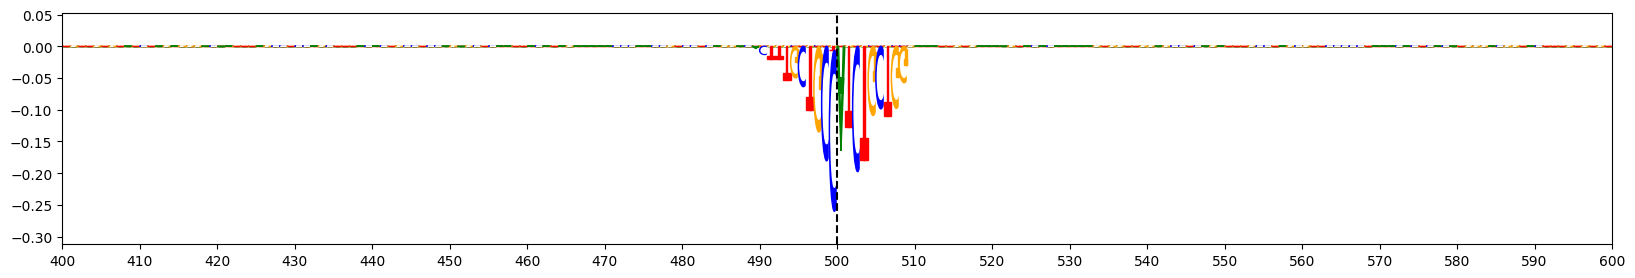

Index:  417  Importance:  -1.0426801156  RSID:  rs344792
Noneffect Allele:  G  Noneffect Sequence:  CTAGTCTCAGACTCCTACCT


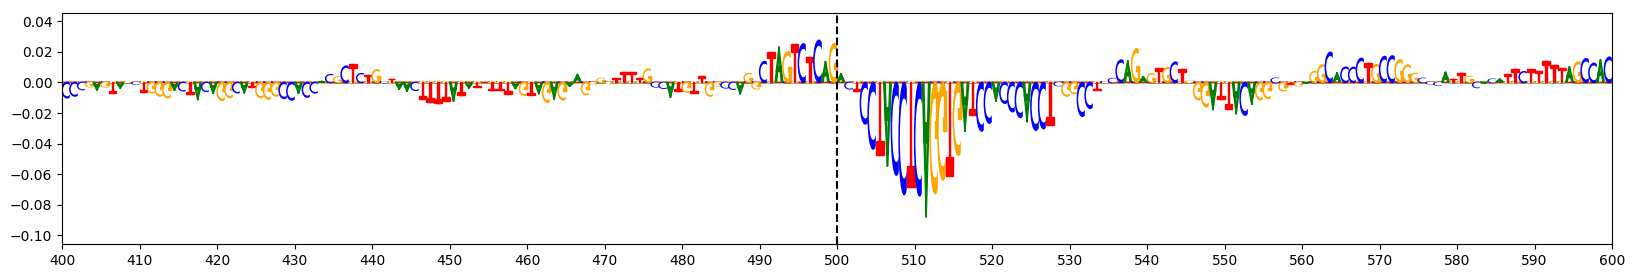

Index:  417  Importance:  -1.5372086925000001  RSID:  rs344792   chr19 : 45326123 - 45326124
Effect Allele:  A  Effect Sequence:  CTAGTCTCAAACTCCTACCT


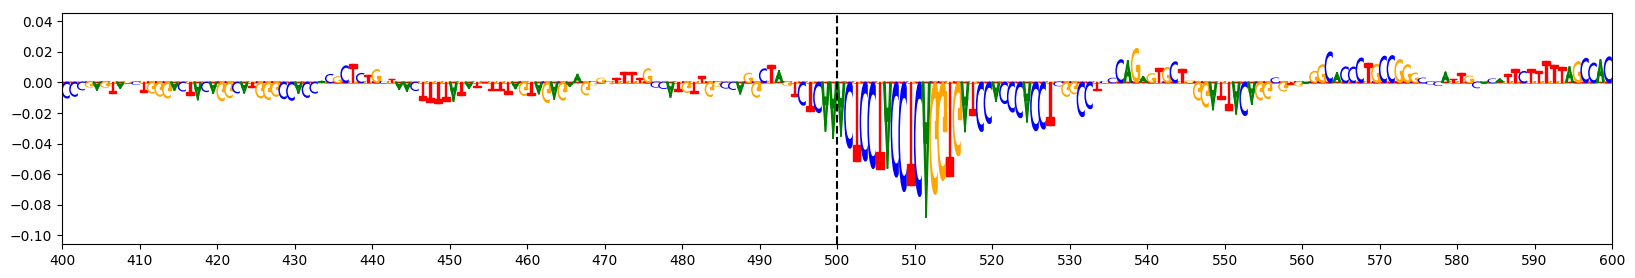

Index:  417  Allele Ratio:  0.19824603009536113  RSID:  rs344792
Effect - Noneffect:  A - G


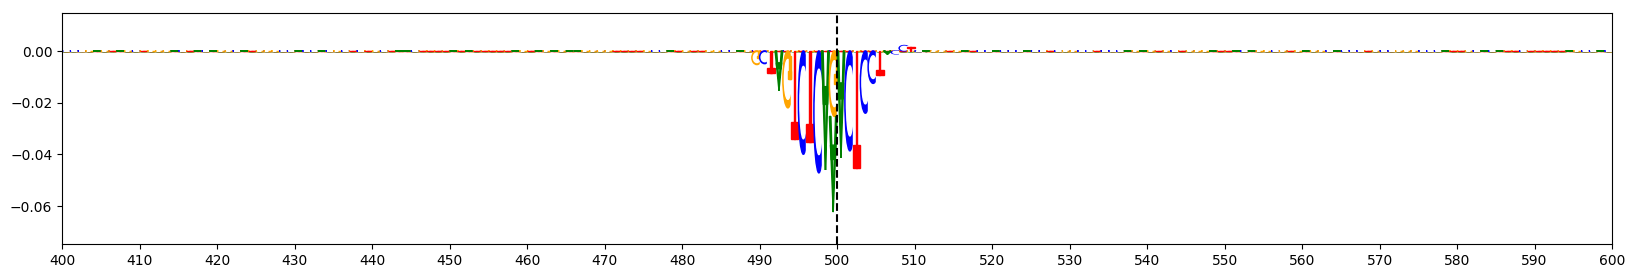

Index:  629  Importance:  -0.38897680300000004  RSID:  rs755951
Noneffect Allele:  C  Noneffect Sequence:  TTCACTGGCCTGTAGGGGGA


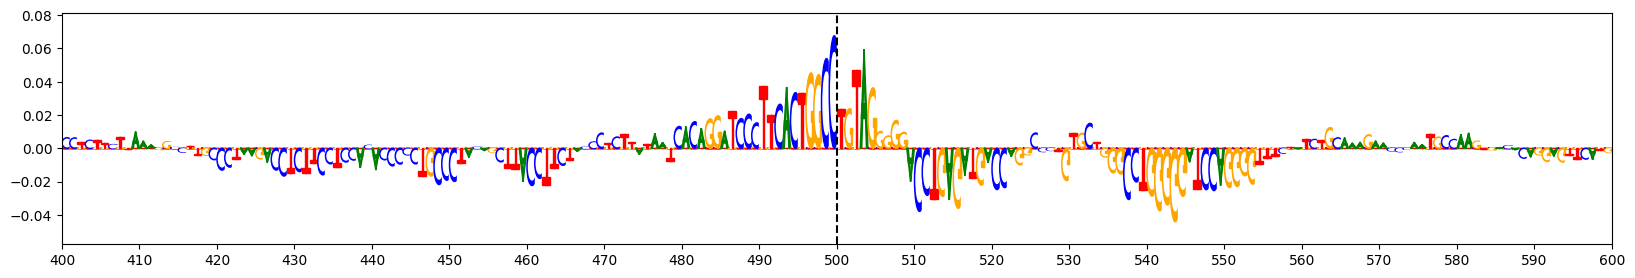

Index:  629  Importance:  -0.9586239360000002  RSID:  rs755951   chr8 : 27369272 - 27369273
Effect Allele:  A  Effect Sequence:  TTCACTGGCATGTAGGGGGA


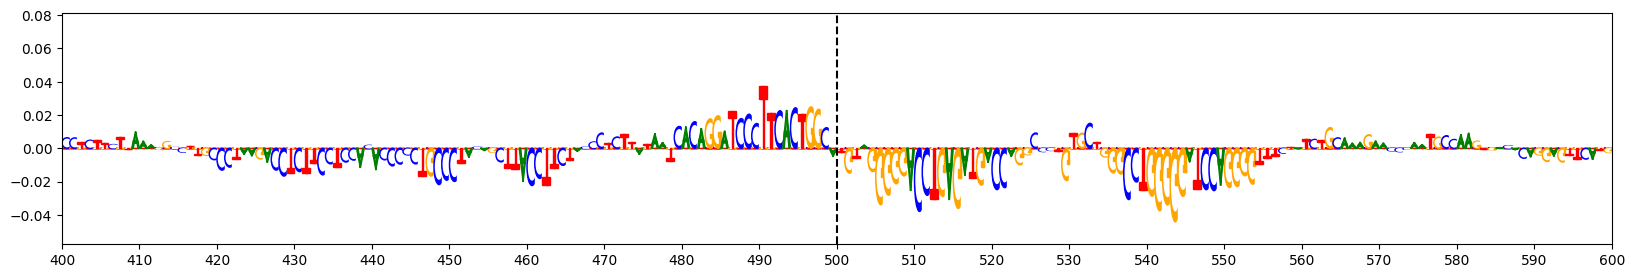

Index:  629  Allele Ratio:  0.4895155578172472  RSID:  rs755951
Effect - Noneffect:  A - C


KeyboardInterrupt: 

In [54]:
for idx in pos_snps.index[:5]:
    #for idx in [60]:
    print("Index: ", idx, " Importance: ", pos_snps.at[idx, 'noneffect_score'], " RSID: ", pos_snps.at[idx, 'rsid'])
    print("Noneffect Allele: ", pos_snps.at[idx, 'noneffect'], ' Noneffect Sequence: ', noneffect_seqs[idx][490:510])
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", pos_snps.at[idx, 'effect_score'], " RSID: ", pos_snps.at[idx, 'rsid'], 
          ' ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'])
    print("Effect Allele: ", pos_snps.at[idx, 'effect'], ' Effect Sequence: ', effect_seqs[idx][490:510])
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Allele Ratio: ", pos_snps.at[idx, 'allele_ratio'], " RSID: ", pos_snps.at[idx, 'rsid'])
    print("Effect - Noneffect: ", pos_snps.at[idx, 'effect'] + ' - ' + pos_snps.at[idx, 'noneffect'])
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))